In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
!pip install transformers
!pip install scikit-learn

In [4]:
import torch
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

import transformers
from sklearn import metrics, model_selection

device = torch.device("cuda")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
data = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
test_data = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
test_data

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
...,...,...,...,...,...
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English


In [7]:
print('Columns and datatypes')
data.dtypes

Columns and datatypes


id            object
premise       object
hypothesis    object
lang_abv      object
language      object
label          int64
dtype: object

In [8]:
data['label'].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

Number of entries per label
entailment       4176
neutral          3880
contradiction    4064
Name: label, dtype: int64


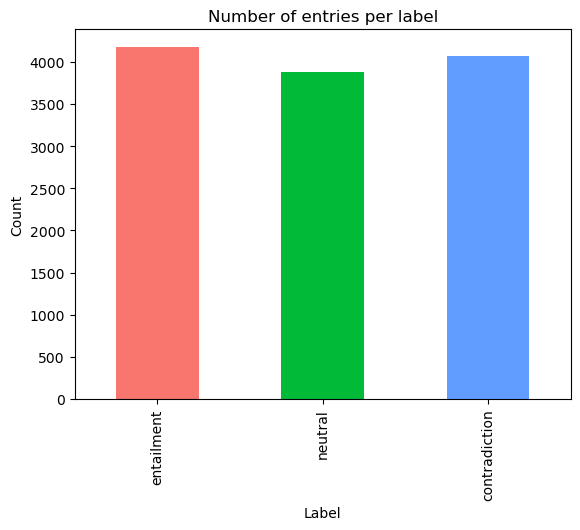

In [9]:
label_count = data['label'].value_counts().sort_index()

label_names = ['entailment', 'neutral', 'contradiction']
label_count.index = label_names

print('Number of entries per label')
print(label_count)

custom_colors = ["#F8766D", "#00BA38", "#619CFF"]

label_count.plot.bar(color=custom_colors)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of entries per label')
plt.show()

Number of entries per language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64


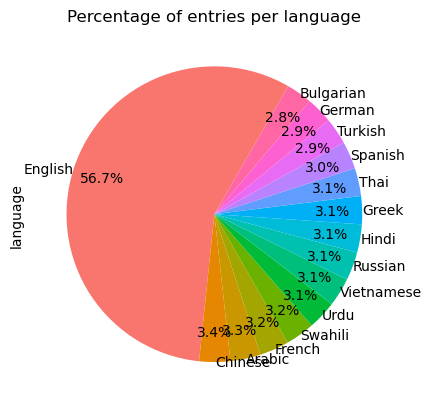

In [10]:
language_count = data['language'].value_counts(sort=True, ascending=False)

print('Number of entries per language')
print(language_count)

custom_colors = ["#F8766D", "#E58700", "#C99800", "#A3A500", "#6BB100", "#00BA38",
                 "#00BF7D", "#00C0AF", "#00BCD8", "#00B0F6", "#619CFF", "#B983FF",
                 "#E76BF3", "#FD61D1", "#FF67A4"]

language_count.plot.pie(colors=custom_colors,
                        autopct='%1.1f%%',
                        pctdistance=0.8,
                        labeldistance=1,
                        startangle=60)
plt.title('Percentage of entries per language')
plt.show()

In [11]:
data.describe(include='object')

,id,premise,hypothesis,lang_abv,language
count,12120,12120,12120,12120,12120
unique,12120,8209,12119,15,15
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English
freq,1,3,2,6870,6870


In [12]:
data = data.drop_duplicates(subset=['premise', 'hypothesis'])
data

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [13]:
data = data.dropna()
data_frame = pd.DataFrame(data, columns=['premise', 'hypothesis', 'language'])

Preprocessing the data

In [14]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.1, random_state=1,stratify=data['label'])

In [15]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d85352e58b05d024ee7f43b92176585820a54399316e11e200df4e4873f74129
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [16]:
# Flan-T5 LLM
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
model_name='google/flan-t5-base'

model_flan_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer_flan_t5 = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [17]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model_flan_t5))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


**mDeBERTa fine-tuned model**

In [18]:
#Zero-Shot Learning
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from transformers import pipeline
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# mDeBERTa fine-tuned model
model_name_mDeBERTa = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer_mDeBERTa = AutoTokenizer.from_pretrained(model_name_mDeBERTa)
model_mDeBERTa = AutoModelForSequenceClassification.from_pretrained(model_name_mDeBERTa)
model_mDeBERTa.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(251000, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [19]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model_mDeBERTa))
#print(print_number_of_trainable_model_parameters(model_xlmRoberta))

trainable model parameters: 278811651
all model parameters: 278811651
percentage of trainable model parameters: 100.00%


In [20]:
premise = "	These are issues that we wrestle with in practice groups of law firms, she said."
hypothesis = "Practice groups are not permitted to work on these issues."
language = "English"

print(f'Zero-Shot Learning Example 1')
dash_line = '-'.join('' for x in range(100))
print(dash_line)

# mDeBERTa Model
input = tokenizer_mDeBERTa(premise, hypothesis, truncation=True, return_tensors="pt")
output = model_mDeBERTa(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()
label_names = ["entailment", "neutral", "contradiction"]
predicted_answer = np.argmax(prediction)
prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print('mDeBERTa:/n',prediction)
print(f'Model: mDeBERTa')
print(predicted_answer)

#Flan T5

prompt = f"""
Compare the below 2 sentences and classify them as entailment, neutral, or contradiction, while considering the language.
sentence 1: {premise}
sentence 2: {hypothesis}
language: {language}

Classification:
"""

inputs = tokenizer_flan_t5(prompt, return_tensors='pt')
output = tokenizer_flan_t5.decode(
    model_flan_t5.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'Model: Flan T5')
print(f'Output\n{output}')


Zero-Shot Learning Example 1
---------------------------------------------------------------------------------------------------
mDeBERTa:/n {'entailment': 0.0, 'neutral': 3.1, 'contradiction': 96.8}
Model: mDeBERTa
2
---------------------------------------------------------------------------------------------------
Model: Flan T5
Output
neutral


In [21]:
# in different language
premise = "	ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้"
hypothesis = "เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร"
language = "Thai"

print(f'Zero-Shot Learning Example 1')
dash_line = '-'.join('' for x in range(100))
print(dash_line)

# mDeBERTa Model
input = tokenizer_mDeBERTa(premise, hypothesis, truncation=True, return_tensors="pt")
output = model_mDeBERTa(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()
label_names = ["entailment", "neutral", "contradiction"]
predicted_answer = np.argmax(prediction)
prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print('mDeBERTa:/n',prediction)
print(f'Model: mDeBERTa')
print(predicted_answer)

#Flan T5

prompt = f"""
Compare the below 2 sentences and classify them as entailment, neutral, or contradiction, while considering the language.
sentence 1: {premise}
sentence 2: {hypothesis}
language: {language}

Classification:
"""

inputs = tokenizer_flan_t5(prompt, return_tensors='pt')
output = tokenizer_flan_t5.decode(
    model_flan_t5.generate(
        inputs["input_ids"], 
        max_new_tokens=200,
    )[0], 
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'Model: Flan T5')
print(f'Output\n{output}')


Zero-Shot Learning Example 1
---------------------------------------------------------------------------------------------------
mDeBERTa:/n {'entailment': 0.4, 'neutral': 99.4, 'contradiction': 0.2}
Model: mDeBERTa
1
---------------------------------------------------------------------------------------------------
Model: Flan T5
Output
neutral


**Full Fine Tuning**

Tokenization

In [22]:
def encode_batch(data):
    start_prompt = 'Compare the premise and hypothesis and classify them as entailment, neutral, or contradiction, while considering the language.\n\n'
    end_prompt = '\n\n Classification: '
    
    input_ids_list = []
    attention_mask_list = []

    prompts = [start_prompt + premise + hypothesis + language + end_prompt for premise, hypothesis, language in zip(data["premise"], data["hypothesis"], data["language"])]
    tokenized_prompts = tokenizer_flan_t5.batch_encode_plus(prompts, padding="max_length", truncation=True, return_tensors="pt")['input_ids']

    return tokenized_prompts

train_input_ids = encode_batch(train_data).to(device)
val_input_ids = encode_batch(val_data).to(device)
test_input_ids = encode_batch(test_data).to(device)
train_input_ids.shape

torch.Size([10908, 512])

In [23]:
import torch

# Assuming you have defined "train_input_ids" as a PyTorch tensor
# Assuming you have "train_data" as a pandas DataFrame
# And you have already tokenized the "train_data" to get "train_input_ids"

# Create a list of indices to keep every 100th example
indices_to_keep = list(range(0, len(train_data), 100))

try:
    # Select the examples based on the indices
    train_input_ids = train_input_ids[indices_to_keep].to(device)
except KeyError as e:
    # Handle KeyError if the index is not found in the DataFrame
    print("Error occurred while filtering:", e)
    print("Please check if the indices_to_keep are valid and within the range of the DataFrame.")
    # Optionally, you can adjust the indices_to_keep list to ensure it only contains valid indices.
    # For example, you can do:
    # indices_to_keep = [i for i in indices_to_keep if i < len(train_data)]
    # And then try filtering again.
train_input_ids.shape

torch.Size([110, 512])

In [24]:
import time
output_dir = f'./classification-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

trainer = Trainer(
    model=model_flan_t5,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data 
)

In [25]:
# List of problematic indices
problematic_indices = [2468, 9792, 9428, 9811, 9072, 8751, 7352, 1619, 2838, 10575, 1133, 4033, 9796, 3388, 3085, 1003,3415]  # Add other indices that caused errors here

# Function to safely drop rows from a DataFrame
def safe_drop_row(df, index):
    try:
        df.drop(index, inplace=True)
        print(f"Dropped row at index {index} from DataFrame.")
    except KeyError:
        print(f"Could not drop row at index {index} from DataFrame. KeyError occurred.")
        pass  # Continue to the next index if KeyError occurs

# Remove the problematic rows from Train Data
for index in problematic_indices:
    safe_drop_row(train_data, index)

# Remove the problematic rows from Eval Data (if they exist)
for index in problematic_indices:
    safe_drop_row(val_data, index)
#By using the pass statement inside the except KeyError block, the code will continue with the next iteration even if a KeyError occurs while trying to drop a specific row. This way, you can handle unknown row numbers without the code terminating prematurely. The script will try to drop all the problematic rows from both DataFrames and print a message for each operation, whether successful or not.


Dropped row at index 2468 from DataFrame.
Dropped row at index 9792 from DataFrame.
Dropped row at index 9428 from DataFrame.
Dropped row at index 9811 from DataFrame.
Dropped row at index 9072 from DataFrame.
Could not drop row at index 8751 from DataFrame. KeyError occurred.
Dropped row at index 7352 from DataFrame.
Dropped row at index 1619 from DataFrame.
Dropped row at index 2838 from DataFrame.
Dropped row at index 10575 from DataFrame.
Dropped row at index 1133 from DataFrame.
Dropped row at index 4033 from DataFrame.
Dropped row at index 9796 from DataFrame.
Dropped row at index 3388 from DataFrame.
Dropped row at index 3085 from DataFrame.
Dropped row at index 1003 from DataFrame.
Dropped row at index 3415 from DataFrame.
Could not drop row at index 2468 from DataFrame. KeyError occurred.
Could not drop row at index 9792 from DataFrame. KeyError occurred.
Could not drop row at index 9428 from DataFrame. KeyError occurred.
Could not drop row at index 9811 from DataFrame. KeyErr

In [26]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.train()                                                                              │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1862 in _inner_training_loop     │
│                                                                                                  │
│   1859 │   │   self._globalstep_last_logged = self.state.global_step                             │
│   1860 │   │   model.zero_grad()                                                                 │
│   1861 │   │                                                                                     │
│ ❱ 1862 │   │   self.control = self.callback_handler.on_train_begin(args, self.state, self.contr  │
│   1863 │   │                                                                                     │
│   1864 │   │   # Skip the first epochs_trained epochs to get the random state of the dataloader  │
│   1865 │   │   if not args.ignore_data_skip:                                                     │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer_callback.py:353 in on_train_begin   │
│                                                                                                  │
│   350 │                                                                                          │
│   351 │   def on_train_begin(self, args: TrainingArguments, state: TrainerState, control: Trai   │
│   352 │   │   control.should_training_stop = False                                               │
│ ❱ 353 │   │   return self.call_event("on_train_begin", args, state, control)                     │
│   354 │                                                                                          │
│   355 │   def on_train_end(self, args: TrainingArguments, state: TrainerState, control: Traine   │
│   356 │   │   return self.call_event("on_train_end", args, state, control)                       │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer_callback.py:397 in call_event       │
│                                                                                                  │
│   394 │                                                                                          │
│   395 │   def call_event(self, event, args, state, control,

In [ ]:
from transformers import Trainer, TrainingArguments

# Define the TrainingArguments and Trainer as before
# ...

# Instantiate the trainer as before
trainer = Trainer(
    model=model_flan_t5,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data 
)

# Print the length of the DataFrames
print("Train Data Length:", len(trainer.train_dataset))
print("Eval Data Length:", len(trainer.eval_dataset))

# Train the model
trainer.train()


In [ ]:
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

# Instantiate the trainer as before
trainer = Trainer(
    model=model_flan_t5,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data 
)

# Print the length of the DataFrames
print("Train Data Length:", len(trainer.train_dataset))
print("Eval Data Length:", len(trainer.eval_dataset))

# Debugging: Print the rows corresponding to index 2468
print("Row at index 2468 in Train Data:")
print(train_data.iloc[2468])
print("Row at index 2468 in Eval Data:")
print(val_data.iloc[2468])

# Train the model
trainer.train()


In [ ]:
def convert_to_bert_input_ids(hypotheses, premises):
    encode_plus = tokenizer.encode_plus(
        hypotheses,
        premises,
        add_special_tokens=True,
        max_length=50,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    return encode_plus

def encode_batch(data):
    hypotheses = data['hypothesis'].values.tolist()
    premises = data['premise'].values.tolist()

    input_ids_list = []
    attention_mask_list = []

    for i in range(len(data)):
        batch_hypotheses = hypotheses[i]
        batch_premises = premises[i]
        data_tokens = convert_to_bert_input_ids(batch_hypotheses, batch_premises)
        input_ids_list.append(data_tokens['input_ids'])
        attention_mask_list.append(data_tokens['attention_mask'])

    # Concatenate the tensors and move to GPU
    input_ids_tensor = torch.cat(input_ids_list, dim=0).to(device)
    attention_mask_tensor = torch.cat(attention_mask_list, dim=0).to(device)

    return input_ids_tensor, attention_mask_tensor

train_input_ids, train_attention_mask = encode_batch(train_data)
val_input_ids, val_attention_mask = encode_batch(val_data)
test_input_ids, test_attention_mask = encode_batch(test_data)


In [ ]:
def convert_to_bert_input_ids(hypotheses,premises):
    encode_plus = tokenizer.encode_plus(
      hypotheses,
      premises,
      add_special_tokens = True,
      max_length = 50,
      return_token_type_ids = False,
      pad_to_max_length=True,
      return_attention_mask = True,
      return_tensors = 'pt',
      truncation = True)
    return encode_plus

In [ ]:
import time
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

output_dir = f'./training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=1,
    max_steps=1
)

def convert_to_bert_input_ids(hypotheses, premises):
    encode_plus = tokenizer.encode_plus(
        hypotheses,
        premises,
        add_special_tokens=True,
        max_length=50,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    return encode_plus

def encode_batch(data):
    hypotheses = data['hypothesis'].values.tolist()
    premises = data['premise'].values.tolist()
    
    input_ids_list = []
    attention_mask_list = []

    for i in range(len(data)):
        batch_hypotheses = hypotheses[i]
        batch_premises = premises[i]
        data_tokens = convert_to_bert_input_ids(batch_hypotheses, batch_premises)
        input_ids_list.append(data_tokens['input_ids'].squeeze(0))         # Remove batch dimension
        attention_mask_list.append(data_tokens['attention_mask'].squeeze(0)) # Remove batch dimension

    return [
        {'input_ids': input_ids, 'attention_mask': attention_mask}
        for input_ids, attention_mask in zip(input_ids_list, attention_mask_list)
    ]

train_features = encode_batch(train_data)
val_features = encode_batch(val_data)

# DataCollator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model_mDeBERTa,
    args=training_args,
    train_dataset=train_features,
    eval_dataset=val_features,
    data_collator=data_collator
)

trainer.train()
